In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing

In [38]:
from keras.datasets import cifar10
(patches, labels_train), (tests, labels_test) = cifar10.load_data()

In [34]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])/255

In [39]:
patches, tests = rgb2gray(patches), rgb2gray(tests)

In [40]:
patches, tests = patches.reshape((50000, -1)), tests.reshape((10000, -1))

In [25]:
patchsize = 32
numpatches = 2000
visibleSize = patchsize*patchsize

hiddenSize = 1500
learning_rate = 0.01
epochs = 10
batch_size = 100
regul_weight = 0
sparsity = 0.25
sparsity_weight = 3

In [21]:
def KL(rho, rho_j):
    return rho * tf.log(rho / rho_j) + (1 - rho) * tf.log((1 - rho) / (1 - rho_j))

In [41]:
print(patches.shape, tests.shape)

(50000, 1024) (10000, 1024)


In [42]:
print(np.max(patches), np.min(patches))

1.0 0.0


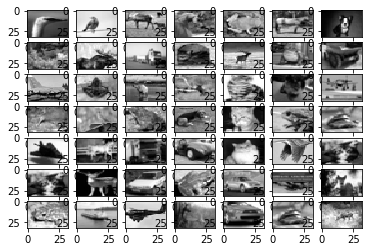

In [43]:
plt.figure()
for i in range(49):
    ax= plt.subplot(7, 7,i+1)
    im=ax.imshow(patches[np.random.randint(0, numpatches), :].reshape([patchsize, patchsize]), cmap='gray', aspect='auto')

In [44]:
data = tf.placeholder(tf.float32, [None, visibleSize])
x = tf.placeholder(tf.float32, [None, visibleSize])
y = tf.placeholder(tf.float32, [None, visibleSize])

r  = np.sqrt(6) / np.sqrt(hiddenSize+visibleSize+1)
W1 = tf.Variable(tf.random_uniform([visibleSize, hiddenSize], -r, r), name='W1')
b1 = tf.Variable(tf.random_normal([hiddenSize]), name='b1')

W2 = tf.Variable(tf.random_uniform([hiddenSize, visibleSize], -r, r), name='W2')
b2 = tf.Variable(tf.random_normal([visibleSize]), name='b2')

hidden_out = tf.add(tf.matmul(x, W1), b1)
hidden_out = tf.nn.sigmoid(hidden_out)

activation = tf.nn.sigmoid(tf.add(tf.matmul(data, W1), b1))

rho = tf.reduce_mean(activation, 0)

y_ = tf.nn.sigmoid(tf.add(tf.matmul(hidden_out, W2), b2))

In [45]:
rho = tf.clip_by_value(rho, 1e-10, 0.9999999)
MSE = tf.reduce_mean(1/2 * tf.square(y_ - y))
regul = tf.reduce_sum(tf.square(W1)) + tf.reduce_sum(tf.square(W2))
penalty = tf.reduce_sum(KL(sparsity, rho))
loss = MSE + regul_weight * regul + sparsity_weight * penalty

In [46]:
optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
init_op = tf.global_variables_initializer()

In [47]:
with tf.Session() as sess:
    sess.run(init_op)
    for epoch in range(epochs):
        avg_cost = 0
        total_batch = int(numpatches / batch_size)
        for i in range(total_batch):
            batch_x = patches[batch_size*i:batch_size*(i+1), :]
            _, c = sess.run([optimiser, loss],
                            feed_dict={x: batch_x, y: batch_x, data: patches})
            avg_cost += c / total_batch
        print("Epoch:", (epoch + 1), "cost =", "{:.8f}".format(avg_cost))
    saver = tf.train.Saver()
    save_path = saver.save(sess, "model")
    print("Model saved in file: %s" % save_path)
    print("Variables saved!")
    feed_dict = {x: patches}
    classification = sess.run(y_, feed_dict)
    X_train = sess.run(hidden_out, feed_dict)
    X_test = sess.run(hidden_out, {x: tests})
    plt.figure()
    for i in range(49):
        ax= plt.subplot(7, 7,i+1)
        im=ax.imshow(classification[i, :].reshape([patchsize, patchsize]), cmap='gray', aspect='auto')
        #First let's load meta graph and restore weights
    # saver = tf.train.import_meta_graph('model.meta')
    # saver.restore(sess,tf.train.latest_checkpoint('./'))
    weights = sess.run(W1)
    plt.figure(figsize=(10, 10))
    weightsize = 15
    for i in range(weightsize*weightsize):
        ax= plt.subplot(weightsize, weightsize,i+1)
        im=ax.imshow(weights[:, i].reshape([patchsize, patchsize]), cmap='gray', aspect='auto')

KeyboardInterrupt: 

In [18]:
import sklearn.decomposition
import sklearn.manifold
from sklearn.metrics import confusion_matrix, accuracy_score
import sklearn.svm

In [19]:
def svm_acc(X_train, y_train, X_test, y_test, C):
    """Trains and evaluates a linear SVM with the given data and C value."""
    clf = sklearn.svm.LinearSVC(C=C, random_state=1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred), confusion_matrix(y_test, y_pred)

In [20]:
y_train = np.sum(labels_train * np.arange(10), axis=1)
y_test = np.sum(labels_test * np.arange(10), axis=1)

In [21]:
for C in np.logspace(-3, 2, 6):
    acc, _ = svm_acc(X_train, y_train, X_test, y_test, C)
    print('C={:.3f}, acc={:.4f}'.format(C, acc))

C=0.001, acc=0.7456
C=0.010, acc=0.8409
C=0.100, acc=0.8855
C=1.000, acc=0.8899
C=10.000, acc=0.8844
C=100.000, acc=0.8830


In [23]:
svm_acc(patches, y_train, tests, y_test, C)[0]

0.84799999999999998

with tf.Session() as sess:
    #First let's load meta graph and restore weights
    saver = tf.train.import_meta_graph('model.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    weights = sess.run(W1)
    plt.figure()
    for i in range(25):
        ax= plt.subplot(5, 5,i+1)
        im=ax.imshow(weights[:, i].reshape([patchsize, patchsize]), cmap='gray', aspect='auto')